## Scaling with N

In this notebook, we investigate the depth number and the gate counts needed for the preparation of the initial state $\ket{\psi_o}$ as a function of the number $N=2^n$ of oscillators with a linear chain connectivity. 

We fix all the masses to be equal to 1000 and all spring constants to be equal to 1, and we also set all initial velocities and displacements equal to 1. We vary the number of oscillators N. 

In [2]:
"""
Import everything here
"""
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time

from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
from classiq.qmod.symbolic import pi
from classiq.execution import IBMBackendPreferences

from classiq.execution import (
    IBMBackendPreferences,
    IBMBackendProvider,
)

In [3]:
import numpy as np

"""
MODEL PARAMETERS to run for identical oscillators with identical initial conditions
"""
#masses
masses_all = 10**4
#sprint constants
spring_constants_all = 1
#initial velocities
vel = 100
#initial displacements
disp = vel

# Specify the maximum value of n
n_max = 5

# Initialize lists to store the results
n_list = list(range(1, n_max + 1))
circuit_width_list = []
circuit_depth_list = []
U_count_list = []
CX_count_list = []
gate_count_list = []
time_list = []

for n in n_list:
    start_time = time.time()   
    N = 2**n

    """
    Define the problem matrices
    """
    masses_all = 1000
    spring_constants = 1
    
    # Create the mass matrix M as an N x N diagonal matrix with all diagonal elements equal to 1000
    M = np.diag([masses_all] * N)

    # Initialize the K matrix with zeros (for oscillators in a linear chain arrangement)
    K = np.zeros((N, N))

    # Fill the K matrix according to the specified pattern
    for i in range(N):
        if i > 0:
            K[i, i-1] = spring_constants_all  # Element (i, i-1)
        K[i, i] = spring_constants_all  # Element (i, i)
        if i < N-1:
            K[i, i+1] = spring_constants_all  # Element (i, i+1)

    # Compute the inverse square root of the mass matrix
    inv_sqrt_M = np.diag(1 / np.sqrt(np.diag(M)))

    # Sq_K matrix whose elements are the square root of the elements of the K matrix 
    Sq_K = np.sqrt(K)

    # F-matrix: Constructed using the spring constants
    F = np.zeros((N, N))
    for j in range(N):
        F[j, j] = np.sum(K[j, :])  # Diagonal elements
        for k in range(N):
            if j != k:
                F[j, k] = -K[j, k]  # Off-diagonal elements

    # A-matrix
    A = inv_sqrt_M @ F @ inv_sqrt_M

    # Initialize the Q matrix (N x (N*(N+1)/2))
    Q = np.zeros((N, N * (N + 1) // 2))

    # Fill the Q matrix based on the formula
    column = 0
    for j in range(N):
        for k in range(j, N):
            if j == k:
                Q[j, column] = Sq_K[j, k]
            else:
                Q[j, column] = Sq_K[j, k]
                Q[k, column] = -Sq_K[j, k]
            column += 1

    # Compute the B matrix
    B = inv_sqrt_M @ Q

    # Create the padded B matrix B_pad
    B_pad = np.zeros((N**2, N**2))
    B_pad[:N, :B.shape[1]] = B

    # Construct the Hamiltonian H
    size_H = N + N * (N + 1) // 2
    H = np.zeros((size_H, size_H))
    H[:N, N:] = B
    H[N:, :N] = B.T

    # Construct the padded Hamiltonian H_pad
    size_H_pad = 2 * N**2
    H_pad = np.zeros((size_H_pad, size_H_pad))
    H_pad[:N**2, N**2:] = B_pad
    H_pad[N**2:, :N**2] = B_pad.T

    """
    Encoding of the problem variables to the initial state
    """

    # Create the lists with all elements set to vel and disp respectively
    ydot_o = np.full(N, vel)
    y_o = np.full(N, disp)

    """
    Extend ydot_o and y_o to form ydot_pad_o and y_pad_o, respectively, with dimension N^2
    """
    ydot_pad_o = np.pad(ydot_o, (0, N**2 - N), mode='constant', constant_values=0)
    y_pad_o = np.pad(y_o, (0, N**2 - N), mode='constant', constant_values=0)

    """
    Calculate jB_pad^\dagger y_pad_o (with j = 1j representing the imaginary unit)
    """
    B_pad_dagger_y_pad_o = 1j * np.dot(B_pad.conj().T, y_pad_o)

    """
    Construct the column vector psi_pad_o
    """
    psi_pad_o = np.concatenate((ydot_pad_o, B_pad_dagger_y_pad_o))

    """
    Store the real part of psi_pad_o to the variable amps
    """
    amps = np.concatenate((np.real(psi_pad_o[:N**2]), np.imag(psi_pad_o[N**2:])))
    amps_norm = np.linalg.norm(amps)
    amps = amps / amps_norm

    """
    Define the matrix U_matrix
    """
    identity = np.eye(N**2)
    identity_j = 1j * np.eye(N**2)
    U_matrix = np.block([
        [identity, np.zeros((N**2, N**2))],
        [np.zeros((N**2, N**2)), identity_j]
    ])

    """
    Quantum algorithm to prepare the initial state
    """
    @qfunc
    def main(x: Output[QArray[QBit]]):
        prepare_amplitudes(amplitudes=amps.tolist(), bound=0.01, out=x)
        unitary(U_matrix.tolist(), x)

    ibm_provider = IBMBackendProvider(
        hub="ibm-q", group="open", project="main"
    )
    preferences = IBMBackendPreferences(
        backend_name="ibm_brisbane",
        access_token="4ee894a607926d14ed854a2f56a9417a8bbffc16a193a51d0e9f95c3a189f0de16f8271c68ad19bebea85717991d115c66bf13d7c33be2f5b3121ac0f04c9973",
        provider=ibm_provider,
    )

    qmod = create_model(main, execution_preferences=preferences)
    qmod_with_constraints = set_constraints(
        qmod, Constraints(optimization_parameter="depth")
    )

    qprog = synthesize(qmod_with_constraints)
    
    circuit_width = QuantumProgram.from_qprog(qprog).data.width
    circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    U_count = QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops["u"]
    CX_count = QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops["cx"]
    gate_count = U_count + CX_count

    circuit_width_list.append(circuit_width)
    circuit_depth_list.append(circuit_depth)
    U_count_list.append(U_count)
    CX_count_list.append(CX_count)
    gate_count_list.append(gate_count)

    N_list = [2**n for n in n_list]
    
    print(f"Running for n = {n}")
    end_time = time.time()
    time_list.append(end_time - start_time)


Running for n = 1
Running for n = 2
Running for n = 3
Running for n = 4


ClassiqAPIError: Call to API failed with code 502
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack

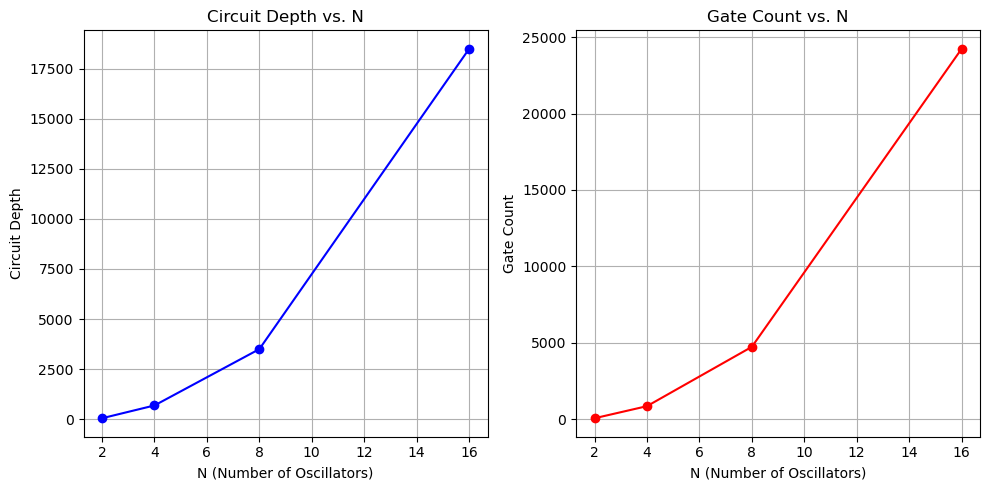

In [28]:
# Define the updated N_lsit remocing the cases of N oscillators for which the program couldn't run.
nn_list = list(range(1, n_max + 1-1))
NN_list = [2**n for n in nn_list]

# Plotting circuit_depth_list vs N_list
plt.figure(figsize=(10, 5))

# Subplot 1: Circuit Depth vs N
plt.subplot(1, 2, 1)
plt.plot(NN_list, circuit_depth_list, marker='o', linestyle='-', color='b')
plt.xlabel('N (Number of Oscillators)')
plt.ylabel('Circuit Depth')
plt.title('Circuit Depth vs. N')
plt.grid(True)

# Subplot 2: Gate Count vs N
plt.subplot(1, 2, 2)
plt.plot(NN_list, gate_count_list, marker='o', linestyle='-', color='r')
plt.xlabel('N (Number of Oscillators)')
plt.ylabel('Gate Count')
plt.title('Gate Count vs. N')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

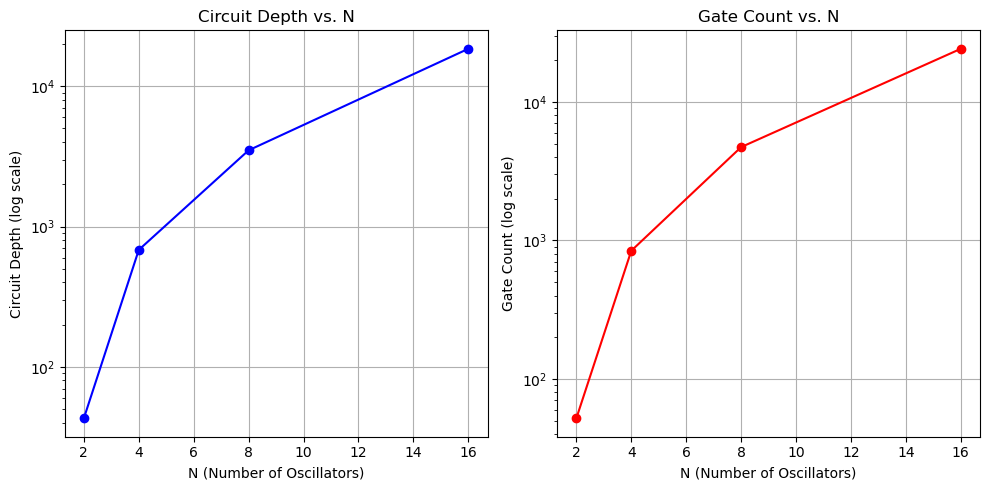

In [30]:
# Plotting circuit_depth_list vs NN_list and gate_count_list vs NN_list with log scale for vertical axis
plt.figure(figsize=(10, 5))

# Subplot 1: Circuit Depth vs N with log scale
plt.subplot(1, 2, 1)
plt.plot(NN_list, circuit_depth_list, marker='o', linestyle='-', color='b')
plt.yscale('log')
plt.xlabel('N (Number of Oscillators)')
plt.ylabel('Circuit Depth (log scale)')
plt.title('Circuit Depth vs. N')
plt.grid(True)

# Subplot 2: Gate Count vs N with log scale
plt.subplot(1, 2, 2)
plt.plot(NN_list, gate_count_list, marker='o', linestyle='-', color='r')
plt.yscale('log')
plt.xlabel('N (Number of Oscillators)')
plt.ylabel('Gate Count (log scale)')
plt.title('Gate Count vs. N')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()
